# Exercise 10: Generative Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
# Use built-in Pytorch function to download MNIST data in usable format 
# the images are automatically normalised to a mean of zero and sigma of 1 

batch_size = 100

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) # initial mean and width
                             ])),
  batch_size=batch_size, shuffle=True)


torch.Size([100, 1, 28, 28])


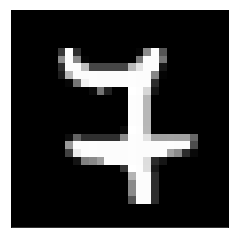

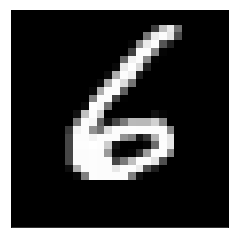

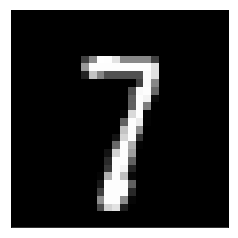

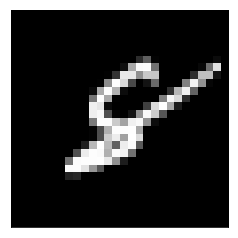

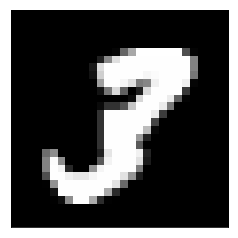

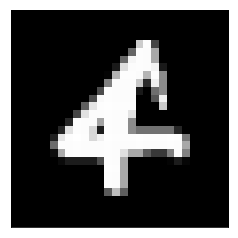

In [4]:
# Helper function to draw MNIST image
# expect a 2D tensor as input
def draw_image(im):
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.show()


examples = enumerate(train_loader)
for batch_idx, (example_data, example_targets) in examples:

    # First print the shape of the example_data tensor
    print(example_data.shape) # 100 examples, 1 color, 28x28 pixel images
    
    # Show the first 6 images
    for i in range(6):
        draw_image(example_data[i][0])
        
    break # Abort the loop over the input data

In [ ]:
# A few useful functions

# Produce random numbers as input for generator
# torch.randn produces random numbers following 
# a Gaussian with mean=0 and sigma=1
def noise(size):
    return torch.autograd.Variable(torch.randn(size, 100))

# Translate images to flat vectors (784 = 28*28)
def images_to_vectors(images):
    return images.view(images.size(0), 784)

# Translate flat vectors to images in the format (color, vertical, horizontal)
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Homework


Implement two networks, named `discriminator` and `generator` (the exact names are important so the subsequent code picks them up correctly). The Discriminator network should receive an input list with 784 features and have one output node. As it does binary discrimination between real and fake images, using a sigmoid for the last layer is recommended. The generator should receive 100 input features (random numbers) and produce a final output of length 784 (28 times 28). Using `tanh` as activiation function for the final layer might be useful. Using the code below, see what image generation results you can acvieve

Produce ten example image after training has completed.

In [ ]:
# Homework: Implement the networks
discriminator = ...
generator = ...

# We need two optimisers, one for the generator, one for the discriminator network
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss() # Binary cross entropy loss function

In [ ]:
# The code below handles the training of the GAN

# Total number of epochs to train
n_epochs = 20 # start with one epoch (you will want to increase this number)

# Loop over epochs
for epoch in range(n_epochs):
    
    # Loop over training examples
    examples = enumerate(train_loader)
    for i_batch, (real_batch, _) in examples:

        # Batch size
        N = real_batch.size(0)
        
        # First Train Discriminator
        real_data = torch.autograd.Variable(images_to_vectors(real_batch))

        # Generate fake data
        # (detach avoid calculating gradients for generator when training discriminator)
        fake_data = generator(noise(N)).detach()

        # Reset gradient
        d_optimizer.zero_grad()
    
        # Train discriminator on real data
        prediction_real = discriminator(real_data)

        # Calculate error and backpropagate
        # We want the discriminator to report "1" for real images
        ones = torch.autograd.Variable(torch.ones(N, 1))
        error_real = loss(prediction_real, ones)
        error_real.backward()

        # Train discriminator on fake data
        prediction_fake = discriminator(fake_data)
        
        # Calculate error and backpropagate
        # We want the discriminator to report "0" for fake images
        zeros =  torch.autograd.Variable(torch.zeros(N, 1))
        error_fake = loss(prediction_fake, zeros)
        error_fake.backward()

        # Update weights with gradients
        d_optimizer.step()

        # Total discriminator error
        d_error =  error_real + error_fake

        # Train Generator
        # Generate fake data
        fake_data = generator(noise(N))

        # Reset gradients
        g_optimizer.zero_grad()

        # Sample noise and generate fake data
        prediction = discriminator(fake_data)

        # Calculate error and backpropagate
        # instead of maximising the loss for zeros we minimise the loss for ones
        ones = torch.autograd.Variable(torch.ones(N, 1))
        g_error = loss(prediction, ones)
        g_error.backward()

        # Update weights with gradients
        g_optimizer.step()

        # Show status every few batches
        if (i_batch) % 50 == 0: 
                        
            test_images = vectors_to_images(generator(noise(1)))
            test_images = test_images.data
            print("Epoch: {0}, Batch: {1}, Error D: {2}, Error G: {3}".format(epoch,i_batch,d_error,g_error))
            draw_image(test_images[0][0])
                
